<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-ввод" data-toc-modified-id="Общий-ввод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий ввод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
#импортируем необходимые библиотеки:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor 

In [2]:
#Откроем таблицу с данными:

data = pd.read_csv('C:\\Users\\vasil\\Downloads\\Vremennye_ryady\\taxi.csv', index_col=[0], parse_dates=[0])
    
display(data.index.is_monotonic)
display(data)

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data= data.resample('1H').sum()

**Вывод:** Представлены данные о заказах такси с 1 марта по 31 августа 2018 года, дата и время заказа были перенесы в индекс, столбец с количеством заказов имеет 26496 строк, пропусков не обнаружено. 

## Анализ

In [5]:
data.index.max() - data.index.min()

Timedelta('183 days 23:00:00')

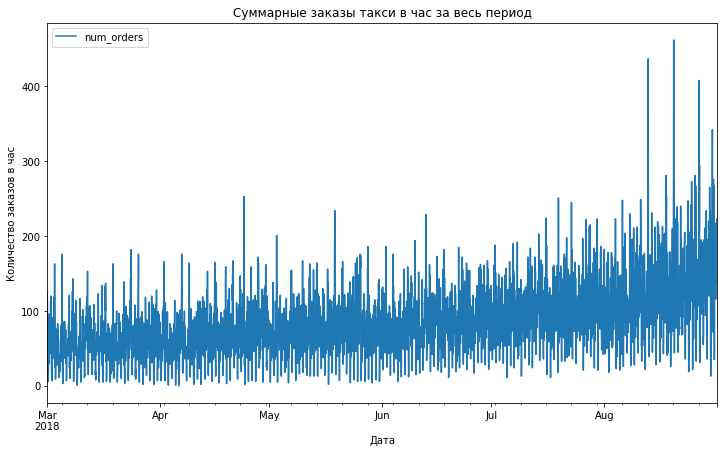

In [6]:
data.plot(ax=plt.gca(),figsize=(12,7))
plt.title("Суммарные заказы такси в час за весь период")
plt.xlabel("Дата")
plt.ylabel("Количество заказов в час")
plt.show()

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


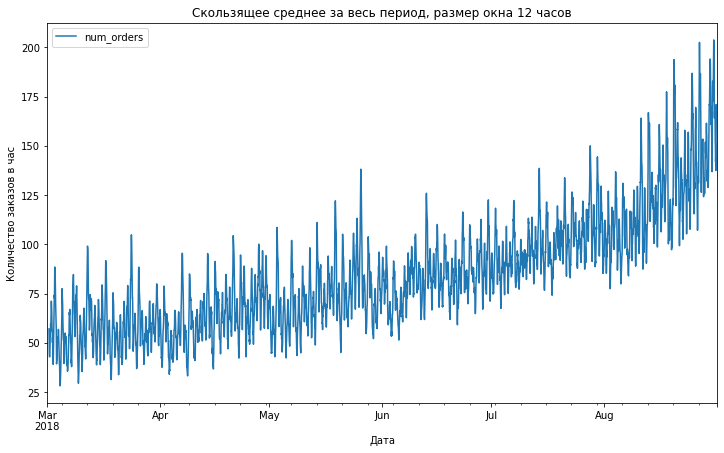

In [8]:
#построим график со скользящим средним, размер окна 12 

data.rolling(12).mean().plot(ax=plt.gca(),figsize=(12,7))
plt.title("Скользящее среднее за весь период, размер окна 12 часов")
plt.xlabel("Дата")
plt.ylabel("Количество заказов в час")
plt.show()

Среднее количество заказов по часам за 183 дня составляет 14 заказов такси, медиана немного меньше (13 заказов), стандарное отклонение 7.5, максимальное значение 77 заказов час. На графике наблюдаются выбивающиеся значения, особенно много их начиная с середины августа. Так же можно заметить возрастающий тренд. Для представления тренда и сезоннности построим графики ниже. 

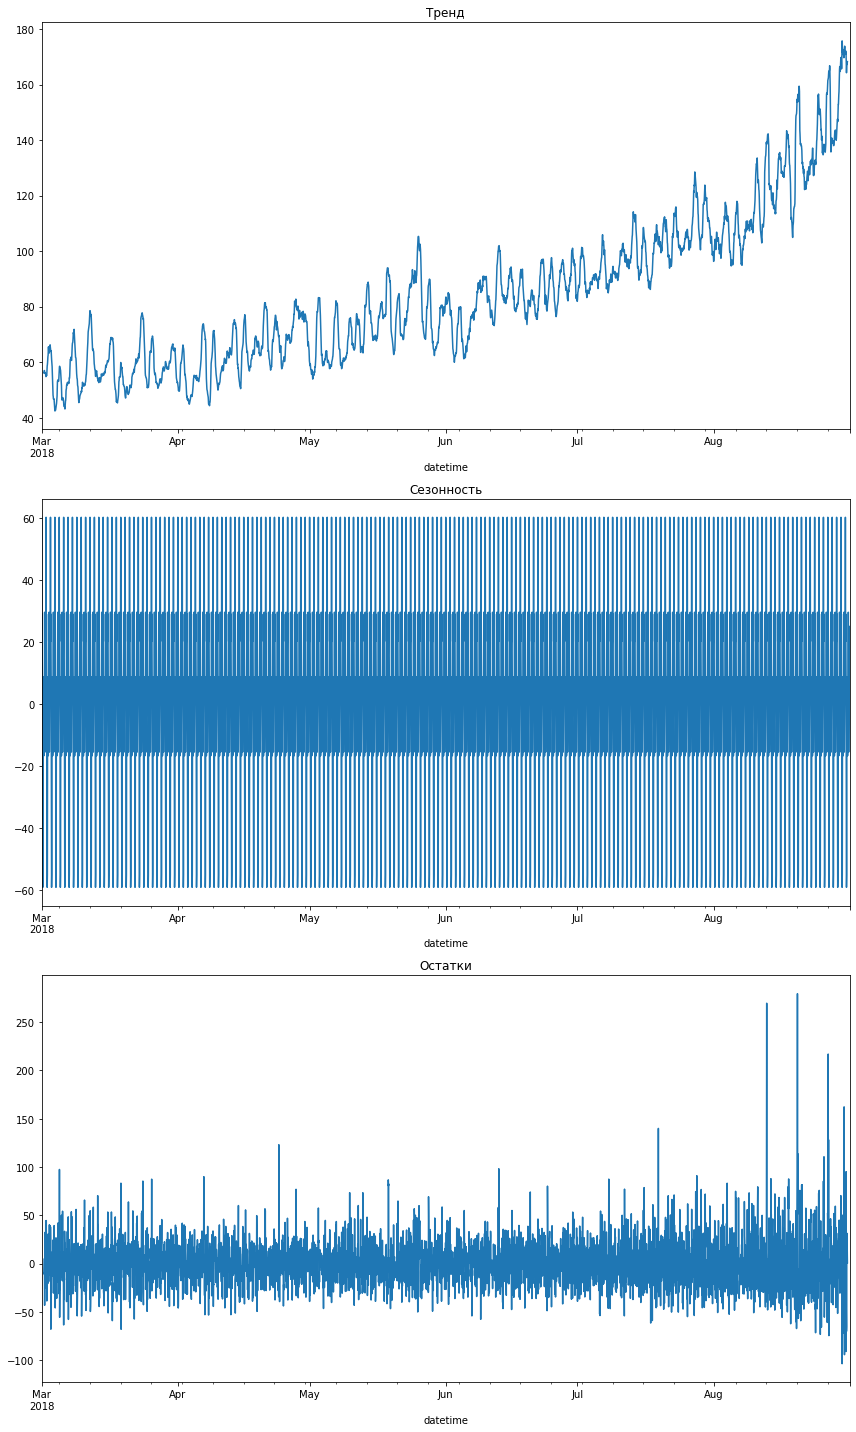

In [9]:
decomposed =  seasonal_decompose(data) 

plt.figure(figsize=(12,20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

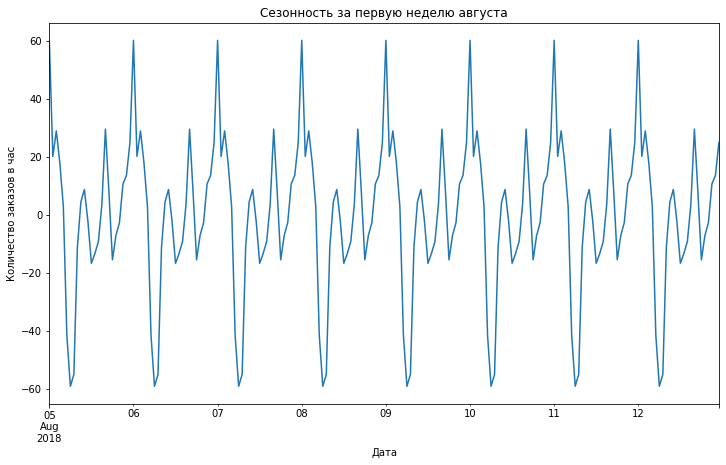

In [10]:
#постороим график сезонности за 1 неделю авгутса 
decomposed.seasonal['2018-08-05':'2018-08-12'].plot(ax=plt.gca(),figsize=(12,7)) 
plt.title("Сезонность за первую неделю августа")
plt.xlabel("Дата")
plt.ylabel("Количество заказов в час")
plt.show()

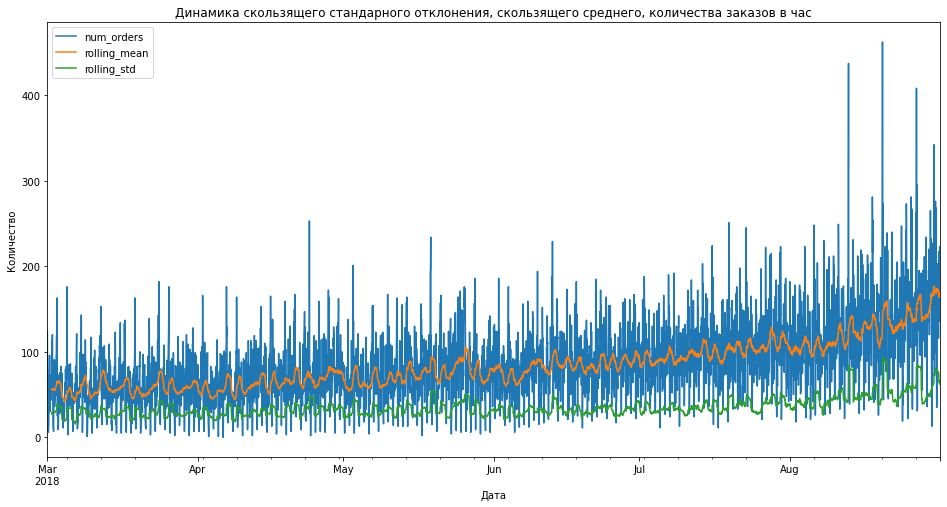

In [11]:
#Построим график демонтсриющий изменение скользящего стандарного отклонения,скользящего среднего, количесива заказов в час

data_rolling_std = data.copy()
data_rolling_std['rolling_mean'] = data_rolling_std.rolling(24).mean()
data_rolling_std['rolling_std'] = data_rolling_std['num_orders'].rolling(24).std()

data_rolling_std.plot(figsize=(16,8))
plt.title("Динамика скользящего стандарного отклонения, скользящего среднего, количества заказов в час")
plt.xlabel("Дата")
plt.ylabel("Количество")
plt.show()

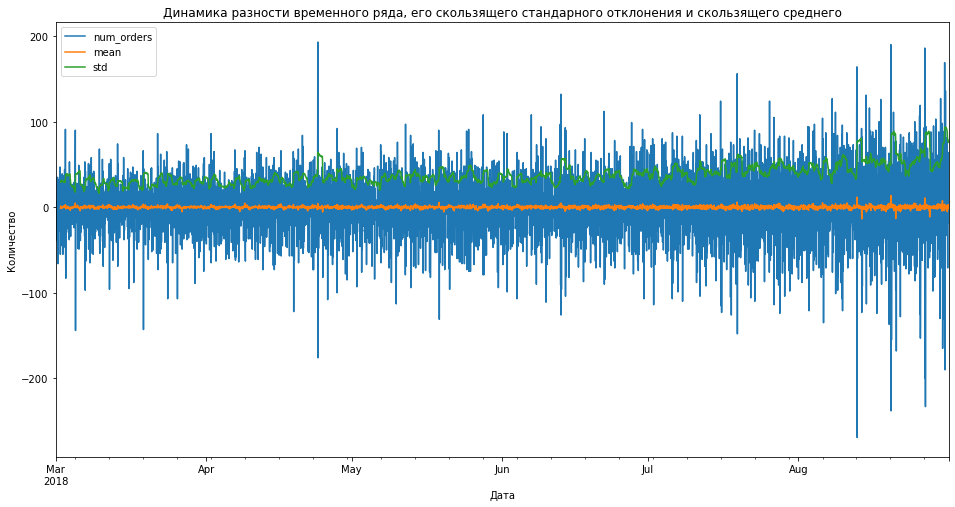

In [12]:
# Найдем разности временного ряда. построим график скользящего среднего стандартного отклонения. 
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(24).mean()
data_shift['std'] = data_shift['num_orders'].rolling(24).std()
data_shift.plot(figsize=(16, 8))
plt.title("Динамика разности временного ряда, его скользящего стандарного отклонения и скользящего среднего")
plt.xlabel("Дата")
plt.ylabel("Количество")
plt.show()

**Вывод:**

Наблюдается восходящий тренд количества заказов. Начиная с середины лета график показывает увеличение темпа роста. 

Сезонность проявляется в течение суток, в середине ночи и ранним утром количество заказов наименьшее, пиковые значения приходятся на вечер вплоть до 12 часов ночи. 

В августе остатки наиболее шумные, много выбивающихся значений, но и присутствуют редкие низкие значения. 

Разности временного ряда сделали его более стационарным. 

## Обучение

Создадим признаки и подготовим выборки для обучения моделей:
    

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [14]:
make_features(data,6,24)
data= data.dropna()
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,56.958333


In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [16]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
#Функция для расчета RMSE 
def rmse(taget, predict):
    return (mean_squared_error(taget, predict)**0.5)

**Обучим модель линейной регрессии:**

In [18]:
lr = LinearRegression(normalize=True)
lr.fit(features_train, target_train)

LinearRegression(normalize=True)

In [19]:
#создадим метрику оценки для кросс-валидации 
rmse_score = make_scorer(rmse, greater_is_better=False)

In [20]:
cv = TimeSeriesSplit(n_splits=5).split(features_train)

In [21]:
lr_rmse = pd.Series(cross_val_score(lr,features_train,target_train,scoring=rmse_score,cv=cv)).mean()
lr_rmse

-31.7310246292299

**Обучим модель случайного леса:**

In [22]:
cv = TimeSeriesSplit(n_splits=5).split(features_train)

forest = RandomForestRegressor()

forest_parametrs = { 'n_estimators': range(5,30,5),
                     'max_depth': range(1, 15, 2),
                    }

forest_grid = GridSearchCV(estimator=forest, param_grid=forest_parametrs, scoring=rmse_score, cv=cv)
forest_grid.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002204A197190>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [23]:
#Лучшие параметры
forest_grid.best_params_

{'max_depth': 13, 'n_estimators': 20}

In [24]:
#Качество модели на кросс-валидации 
forest_grid.score(features_train, target_train)

-12.29766755729739

**Oбучим модель градиентного бустинга:**


In [25]:
cv = TimeSeriesSplit(n_splits=5).split(features_train)

cbr = CatBoostRegressor(verbose=100)

cbr_parametrs = {
              'depth': [4, 6, 8],
              'learning_rate': [0.03, 0.1],
                }

cbr_grid = GridSearchCV(estimator=cbr, param_grid=cbr_parametrs, scoring=rmse_score, cv=cv)
cbr_grid.fit(features_train, target_train)

0:	learn: 29.2248405	total: 147ms	remaining: 2m 26s
100:	learn: 18.0739893	total: 205ms	remaining: 1.82s
200:	learn: 16.3010596	total: 247ms	remaining: 981ms
300:	learn: 14.9582558	total: 286ms	remaining: 664ms
400:	learn: 13.9168097	total: 324ms	remaining: 484ms
500:	learn: 12.9825710	total: 362ms	remaining: 360ms
600:	learn: 12.1923781	total: 399ms	remaining: 265ms
700:	learn: 11.4828174	total: 436ms	remaining: 186ms
800:	learn: 10.7787071	total: 473ms	remaining: 118ms
900:	learn: 10.2191994	total: 510ms	remaining: 56.1ms
999:	learn: 9.7378968	total: 548ms	remaining: 0us
0:	learn: 30.0185433	total: 672us	remaining: 672ms
100:	learn: 20.1428455	total: 49.7ms	remaining: 443ms
200:	learn: 18.4991629	total: 95.4ms	remaining: 379ms
300:	learn: 17.4367345	total: 141ms	remaining: 326ms
400:	learn: 16.6394214	total: 186ms	remaining: 278ms
500:	learn: 15.8550403	total: 231ms	remaining: 230ms
600:	learn: 15.1561757	total: 276ms	remaining: 183ms
700:	learn: 14.5172540	total: 321ms	remaining: 13

300:	learn: 19.1717948	total: 341ms	remaining: 791ms
400:	learn: 18.2948503	total: 450ms	remaining: 673ms
500:	learn: 17.5757285	total: 562ms	remaining: 560ms
600:	learn: 16.9361943	total: 672ms	remaining: 446ms
700:	learn: 16.2622989	total: 784ms	remaining: 334ms
800:	learn: 15.7861739	total: 895ms	remaining: 222ms
900:	learn: 15.2702655	total: 1s	remaining: 110ms
999:	learn: 14.8467578	total: 1.11s	remaining: 0us
0:	learn: 28.1827756	total: 1.2ms	remaining: 1.2s
100:	learn: 11.8535798	total: 88.2ms	remaining: 785ms
200:	learn: 8.0454521	total: 167ms	remaining: 666ms
300:	learn: 5.9140664	total: 245ms	remaining: 569ms
400:	learn: 4.5712574	total: 323ms	remaining: 482ms
500:	learn: 3.5132322	total: 401ms	remaining: 399ms
600:	learn: 2.7644945	total: 478ms	remaining: 317ms
700:	learn: 2.0776967	total: 556ms	remaining: 237ms
800:	learn: 1.5736666	total: 634ms	remaining: 157ms
900:	learn: 1.2210857	total: 711ms	remaining: 78.1ms
999:	learn: 0.9625211	total: 788ms	remaining: 0us
0:	learn: 

700:	learn: 5.3174219	total: 1.72s	remaining: 733ms
800:	learn: 4.5078817	total: 1.96s	remaining: 487ms
900:	learn: 3.9227907	total: 2.2s	remaining: 242ms
999:	learn: 3.3829574	total: 2.44s	remaining: 0us
0:	learn: 33.0823304	total: 3.11ms	remaining: 3.11s
100:	learn: 17.0698780	total: 260ms	remaining: 2.31s
200:	learn: 14.1599563	total: 502ms	remaining: 2s
300:	learn: 11.8808393	total: 749ms	remaining: 1.74s
400:	learn: 10.0731472	total: 999ms	remaining: 1.49s
500:	learn: 8.6653915	total: 1.25s	remaining: 1.24s
600:	learn: 7.5211978	total: 1.5s	remaining: 993ms
700:	learn: 6.5367338	total: 1.74s	remaining: 744ms
800:	learn: 5.7440647	total: 1.99s	remaining: 495ms
900:	learn: 5.0519157	total: 2.24s	remaining: 246ms
999:	learn: 4.4796095	total: 2.49s	remaining: 0us
0:	learn: 38.1993168	total: 9.93ms	remaining: 9.92s
100:	learn: 24.0469820	total: 162ms	remaining: 1.45s
200:	learn: 22.3046716	total: 275ms	remaining: 1.09s
300:	learn: 21.0827613	total: 391ms	remaining: 909ms
400:	learn: 19

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002204AE5C6D0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000022049F8BD90>,
             param_grid={'depth': [4, 6, 8], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [26]:
#Лучшие параметры 
cbr_grid.best_params_

{'depth': 6, 'learning_rate': 0.03}

In [27]:
#Качество модели на кросс-валидации 
cbr_grid.score(features_train, target_train)

-16.2833642421759

**Вывод:** Было обучено три модели, на крос-валидации лучшее качество показала модель случайного леса

## Тестирование

Проверим качество предсказаний модели случайного леса на тестовой выборке:

In [28]:
predict_forest = forest_grid.predict(features_test)

In [29]:
rmse(target_test, predict_forest)

43.45343906545289

**Значение rmse не больше 48, удовляет поставленному условию по качеству предсказаний**

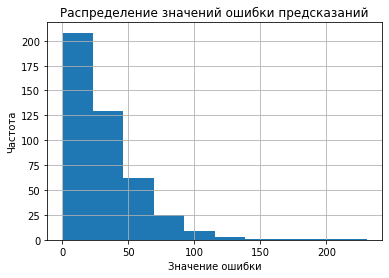

In [30]:
error_abs = abs(predict_forest - target_test)
error_abs.hist()
plt.title("Распределение значений ошибки предсказаний")
plt.xlabel("Значение ошибки")
plt.ylabel("Частота")
plt.show()

In [31]:
error_abs.describe()

count    440.000000
mean      32.263729
std       29.140747
min        0.054797
25%       12.252336
50%       24.907292
75%       43.646652
max      230.641667
Name: num_orders, dtype: float64

In [32]:
target = pd.Series(target_test)
predict = pd.Series(predict_forest,index=features_test.index)

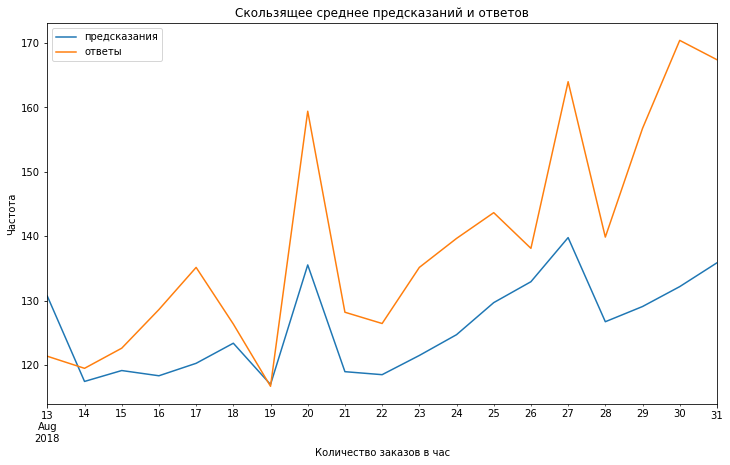

In [33]:
predict.resample('1D').mean().rolling(1).mean().plot(ax=plt.gca(),figsize=(12,7), label='предсказания')
target.resample('1D').mean().rolling(1).mean().plot(ax=plt.gca(),figsize=(12,7), label='ответы')
plt.title("Скользящее среднее предсказаний и ответов")
plt.xlabel("Количество заказов в час")
plt.legend(['предсказания', 'ответы'])
plt.ylabel("Частота")
plt.show()

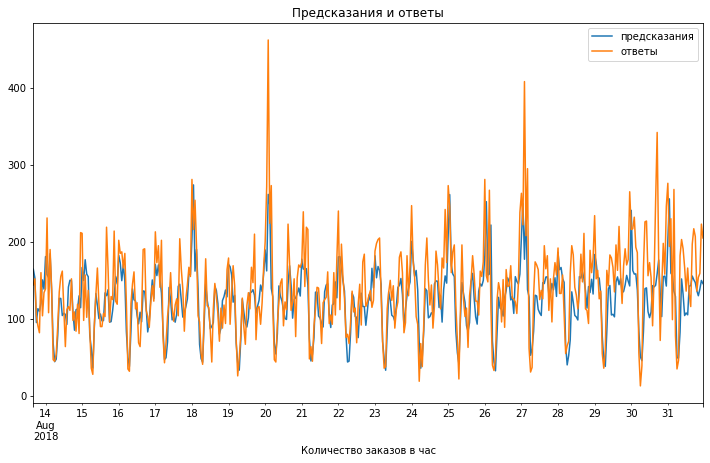

In [34]:
predict.plot(ax=plt.gca(),figsize=(12,7), label='предсказания')
target.plot(ax=plt.gca(),figsize=(12,7), label='ответы')
plt.title("Предсказания и ответы")
plt.xlabel("Количество заказов в час")
plt.legend(['предсказания', 'ответы'])
plt.show()

In [35]:
display(predict.describe())
display('_______')
display(target.describe())

count    440.000000
mean     125.716521
std       40.428452
min       32.609107
25%      101.792318
50%      130.710267
75%      149.532739
max      273.900000
dtype: float64

'_______'

count    440.000000
mean     139.561364
std       58.697602
min       13.000000
25%      104.000000
50%      135.000000
75%      173.000000
max      462.000000
Name: num_orders, dtype: float64

## Общий ввод

Для построения предсказательной модели были сделаны следующие шаги:

     данные заргружены и выполнено ресемплирование по одному часу;
     
     проведен анализ данных и выявлен восходящий тренд количества заказов, а также сезонность проявляется в течение суток (в середине ночи и ранним утром количество заказов наименьшее, пиковые значения приходятся на вечер вплоть до 12 часов ночи;
     
    подготовлены признаки (выбрано использвать 6 остающих занчений, окно для скользящего среднего = 24 часа);
    
    обучены 3 модели (линейной регресси, случайного леса, catboost), лучший rmse на кросс-валидации показала модель случайно леса;
    
    модель случайного леса проверена на тестовой выборке, проходит по условию значение rmse. 

**Ошибки предсказний:** Модель чаще всего предсказывает значения близкие средним. Значительно ошибается, когда случаются выбивающиеся значения. График предсказаний более сглаженный, не имеет таких больших пиков и спадов, как график фактических значений: минимальное предсказанное значение в 2.3 раза меньше, чем фактическое; максимальное предсказанное  в 1.6 раз меньше фактического.